<div>
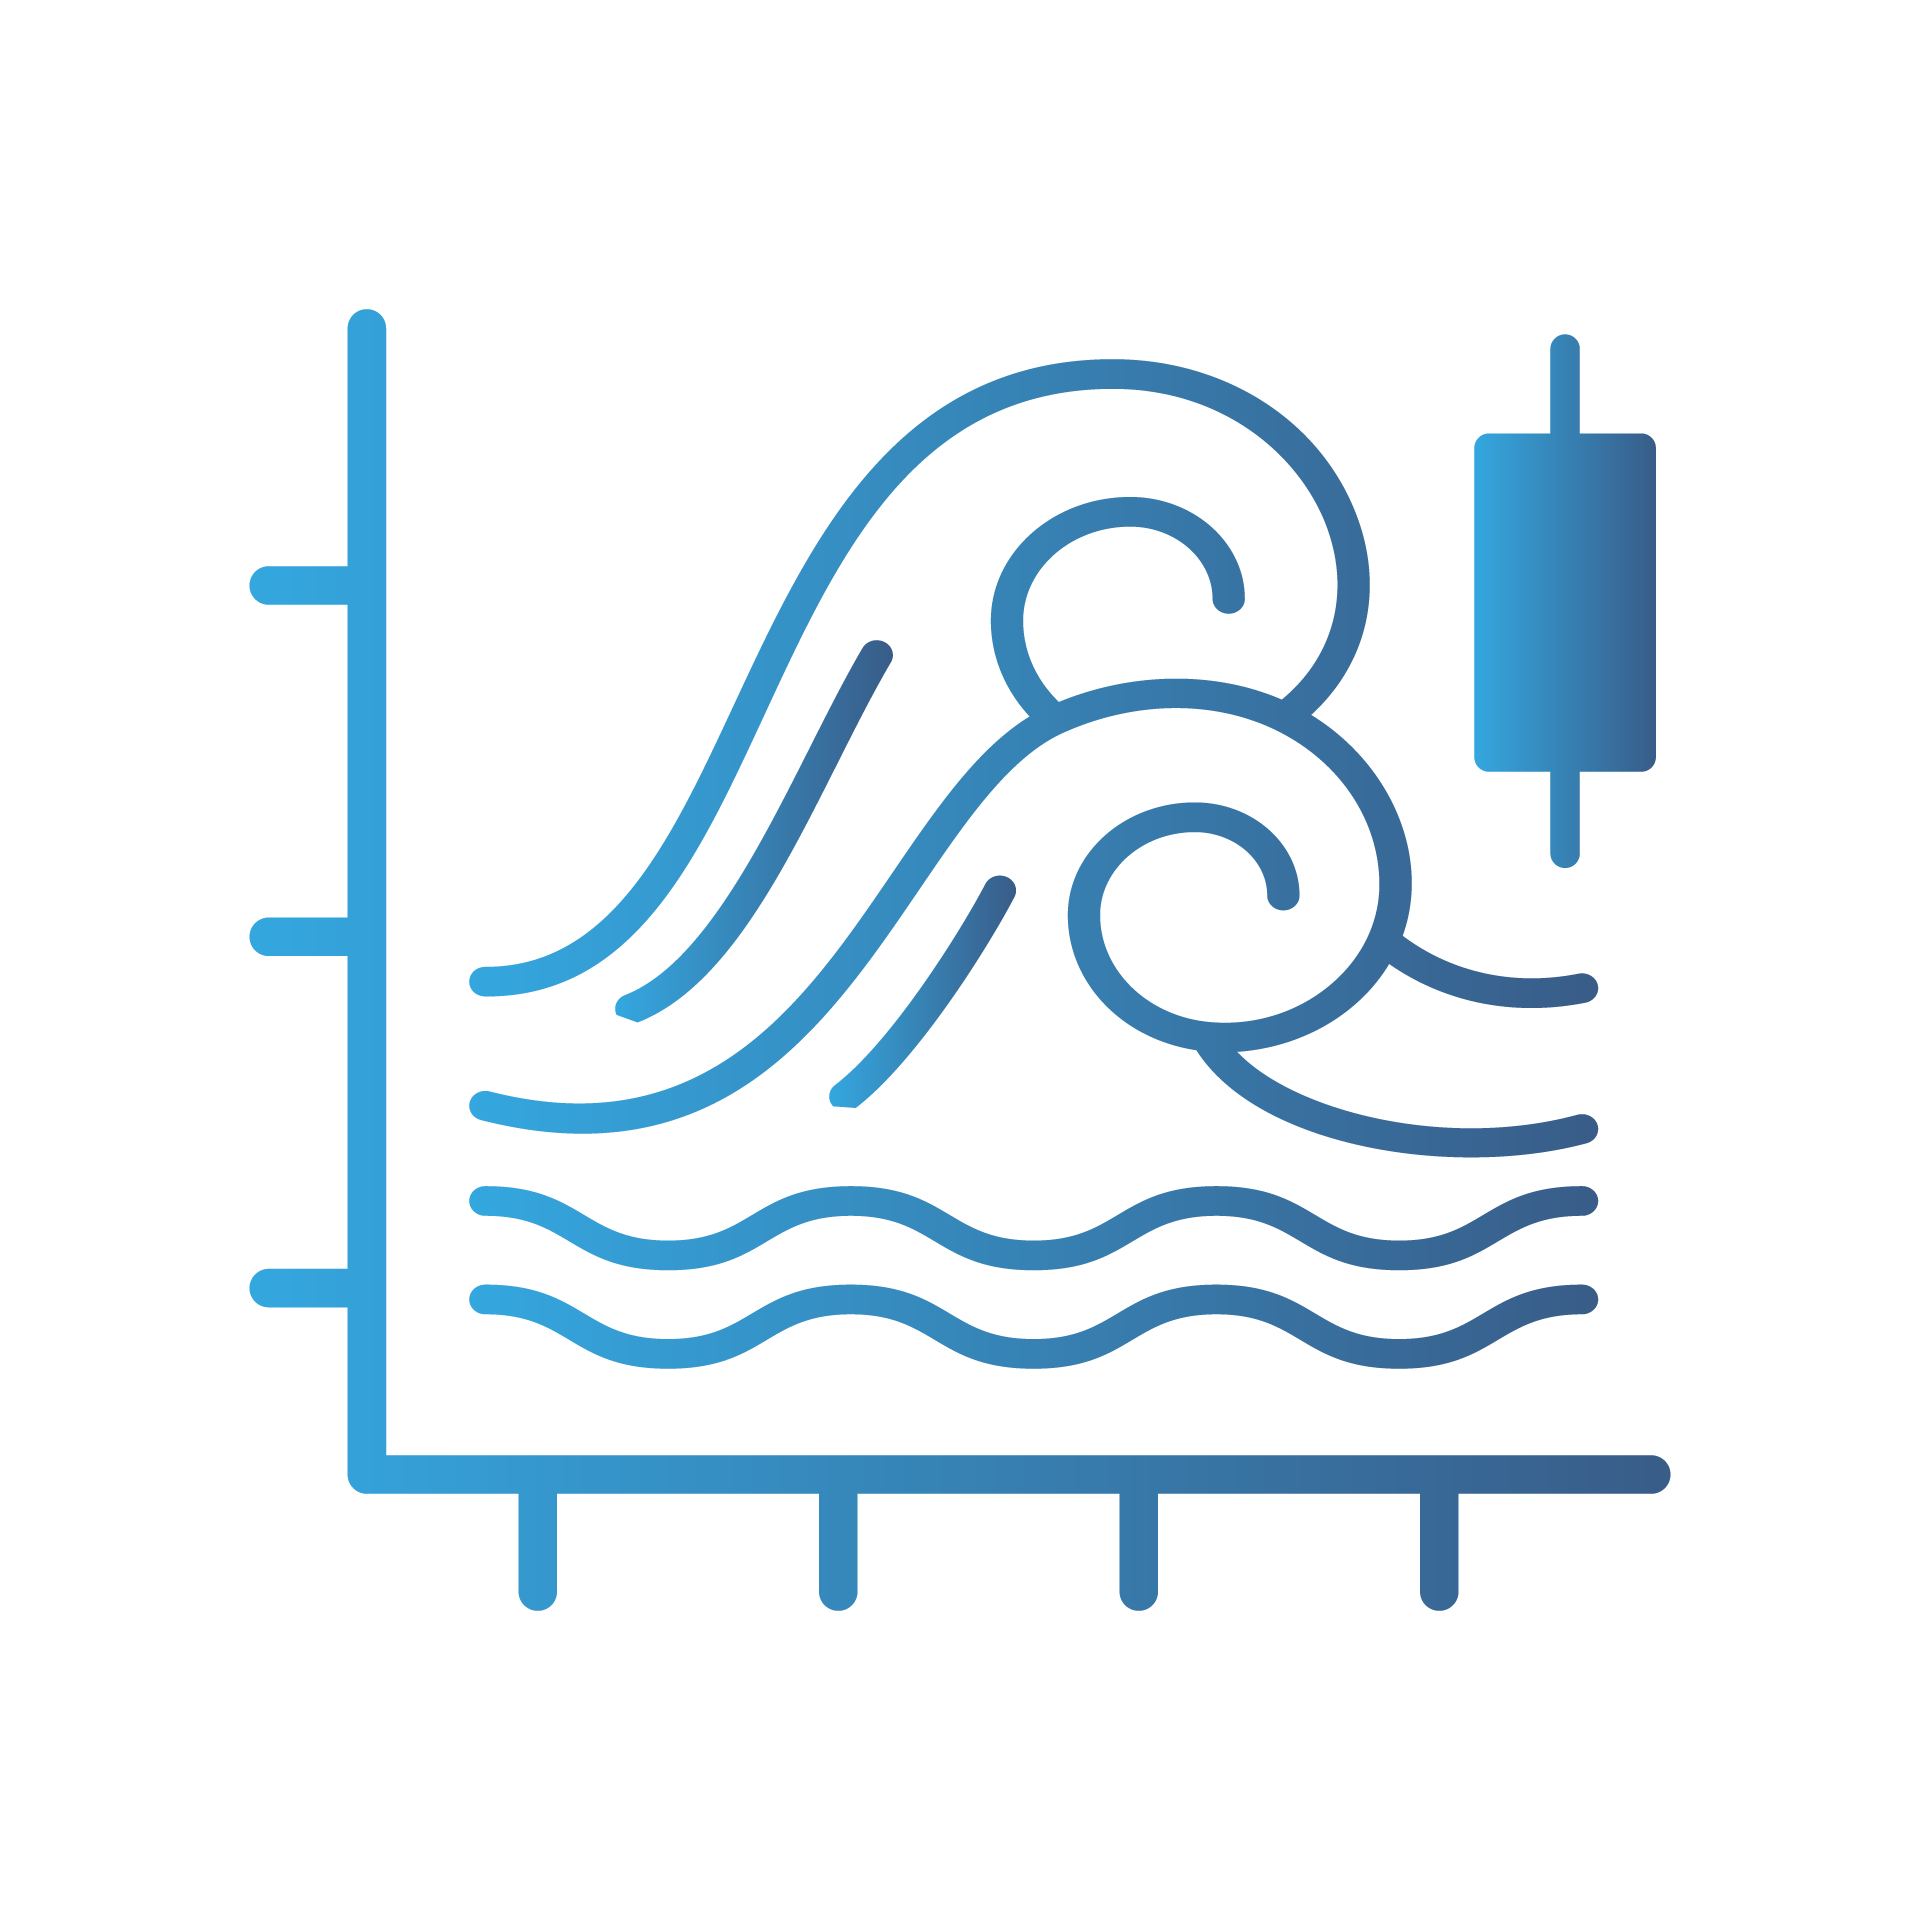
</div>

# __Develop a PCM__

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), and Guillaume Maze (gmaze@ifremer.fr)
***

## Description

**The objective of this notebook is to create a PCM model, optimize the model parameters, and save the PCM for later use.**

A PCM (__Profile Classification Model__) allows to automatically assemble ocean profiles in clusters according to their vertical structure similarities. Depending on the dataset, such clusters can show space/time coherence. That is what we call the __ocean patterns indicator__. For more information about the method, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

As an example, a subset of the ``GLOBAL_REANALYSIS_PHY_001_030`` CMEMS product covering the Mediterranean is available as a training dataset.

Computation is done using the __pyxpcm python software__ (see documentation at https://pyxpcm.readthedocs.io)

The optimized model you are going to create can be saved and later applied to another dataset using the ``predit_PCMlabels_and_plot.ipynb`` notebook, where you can plot and analyze the results.

***
This notebook has been developed at Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Blue-Cloud project. Blue-Cloud has received funding from the European Union's Horizon programme call BG-07-2019-2020, topic: [A] 2019 - Blue Cloud services, Grant Agreement n.862409


<div>
<center>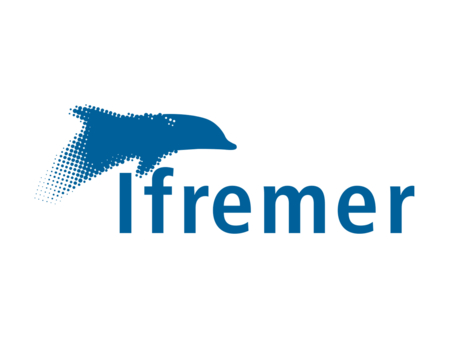 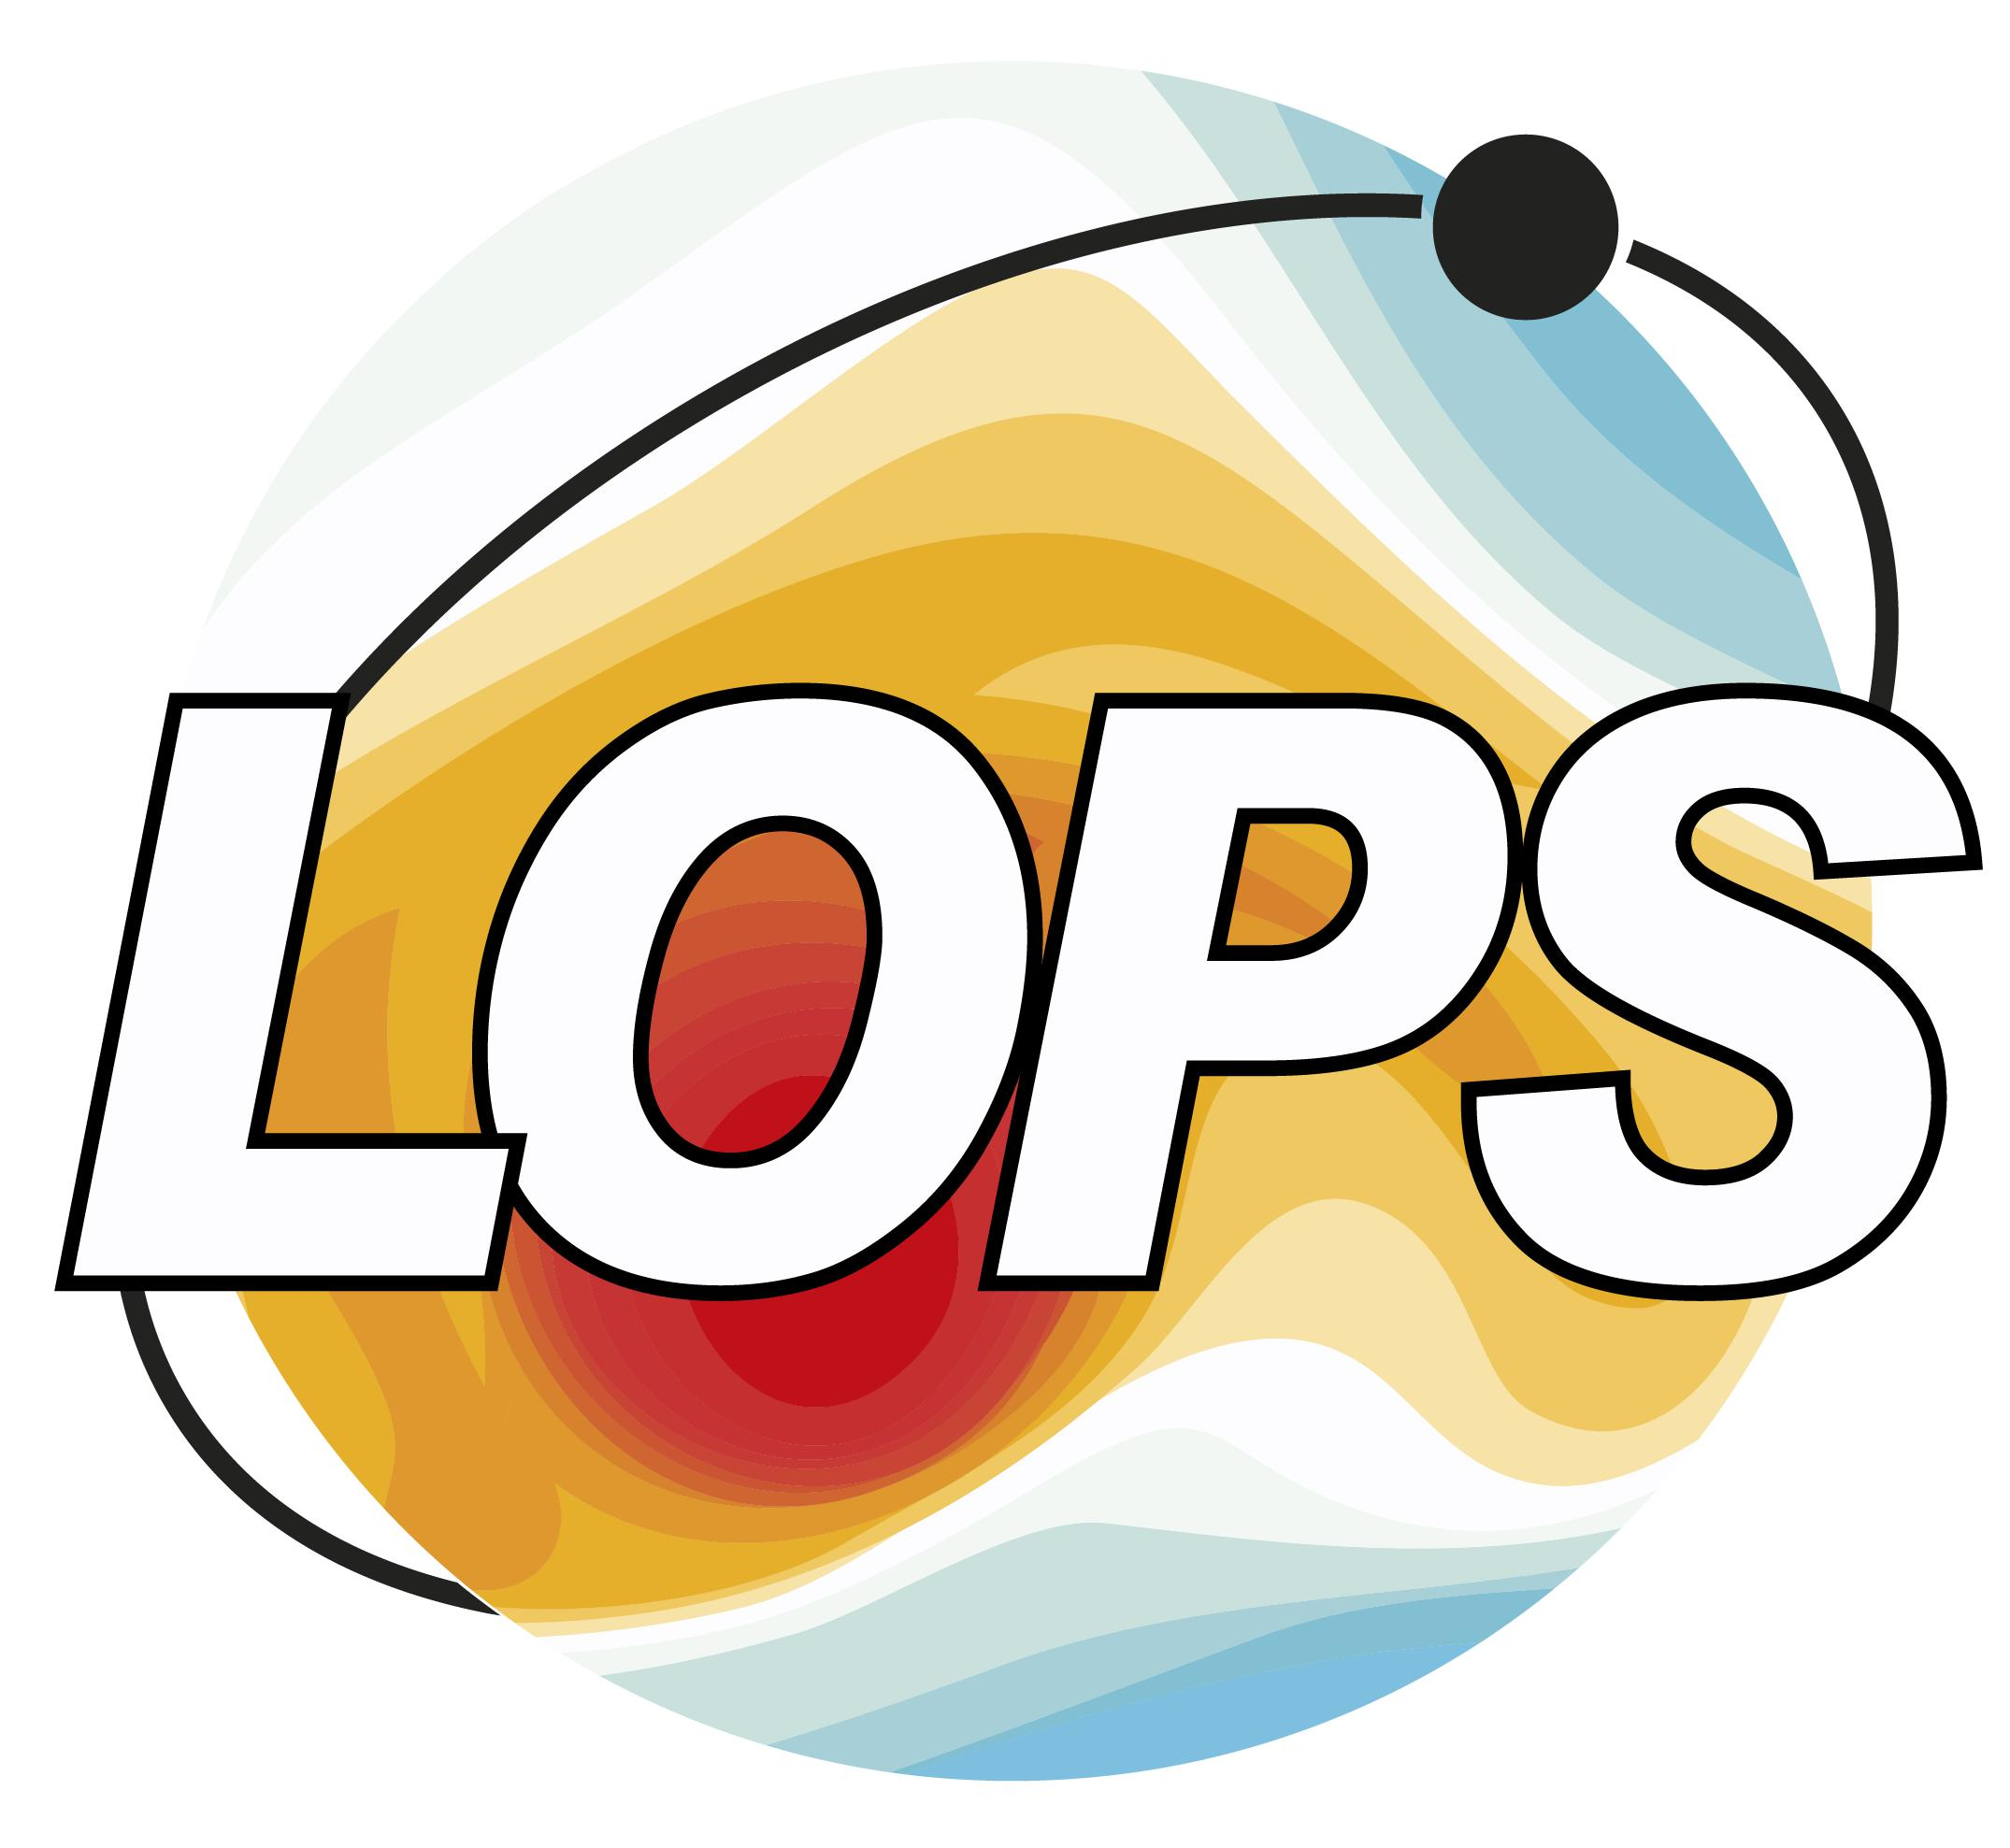 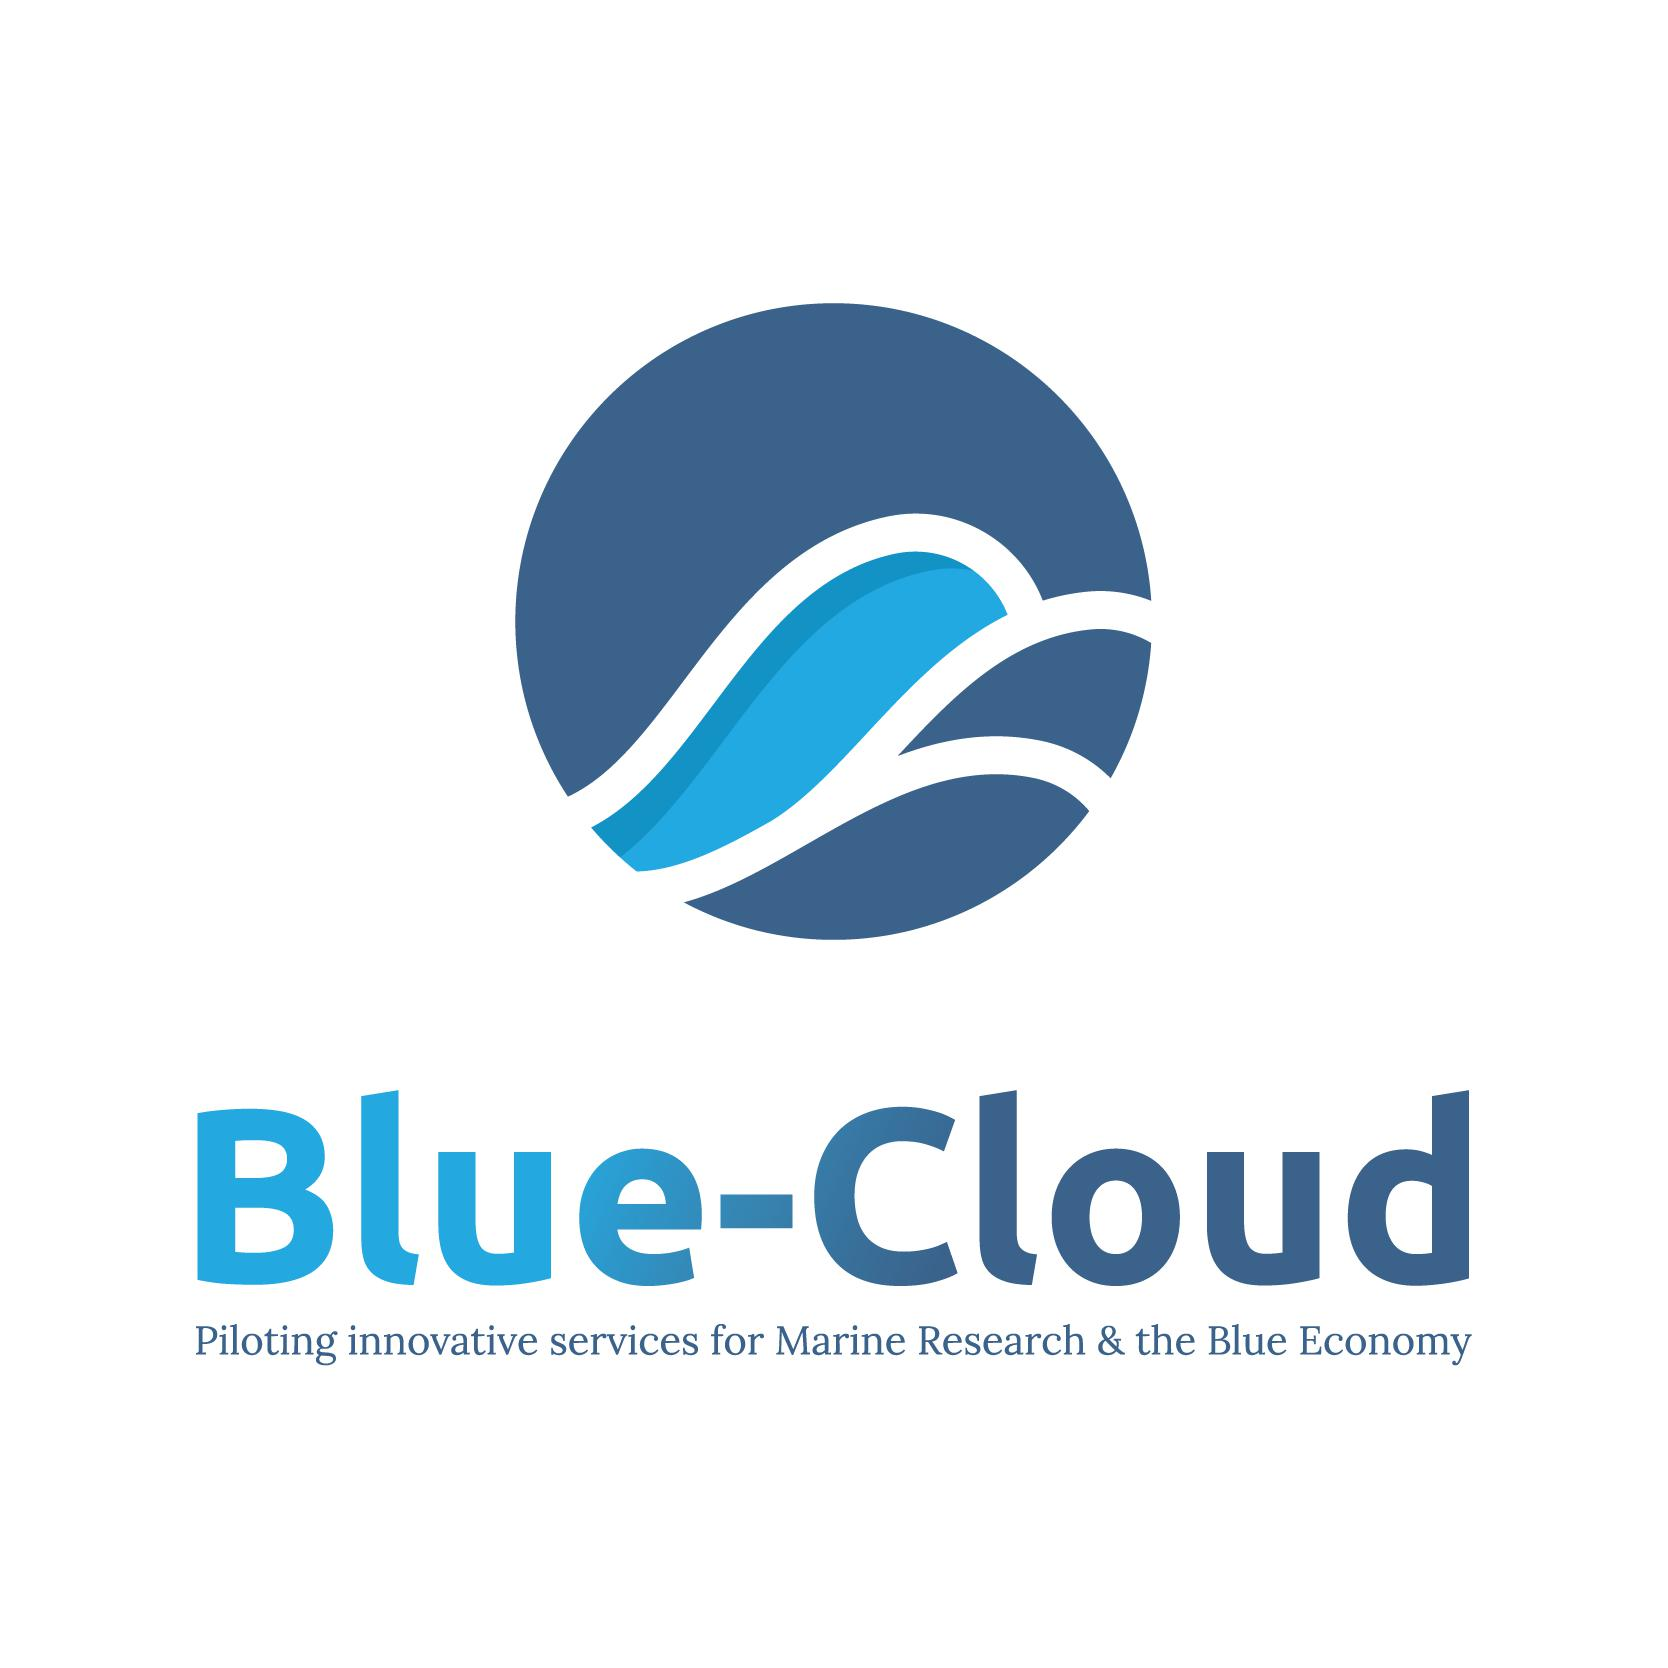</center>
</div>

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

import subprocess

from BIC_calculation import *

## Model parameters
***

__Model parameters__

In this section you will provide the parameters you want to use to design your PCM: you must choose the __number of classes__ and provide the name the variable (__feature__) will have in the model.

For the number of classes *K* you can choose a low number at the beginning (around 6 is a good general start). 
In the plot section, you will optimize the number of classes using the [BIC plot](#BIC_plot). 
Then you will use the optimized number of classes to train the model again.

In [2]:
# number of classes
K=6

# name of variable (feature)
var_name_mdl = 'temperature' # in model

## Load training dataset
***

__Choose training dataset__

The training dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

You should provide your CMEMS __user name__ and __password__ below.

In [3]:
CMEMS_user = '#######'
CMEMS_password = '##########'

Data comes from  monthly mean fields of *GLOBAL_REANALYSIS_PHY_001_030* product, an eddy-resolving reanalysis with 1/12° horizontal resolution and 50 vertical levels (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030) for getting all the information about the dataset). As an example, we propose to you a selection covering the Mediterranean sea during 2018.

If you feel confident you can modify downloading parameters (cell below) to test other dataset selections than the one we propose here (covering the Mediterranean). You can also test other variables, but do not forget to change variables' names in the cell above. And be careful with memory limits: do not choose very big geographical extents or very long time series.

In [4]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2018-01-01", "2018-12-31"] # ["min date", "max date"]
# variable to be predict
var_name_ds = 'thetao' # name in dataset
# file name
file_name = 'global-reanalysis-phy-001-030-monthly_med_2018.nc'

__Load training dataset__

Training dataset is download from __CMEMS__ servers using a Motu client and saved as a NetCDF file in *datasets/* folder in your workspace. Dowloading will take some minutes.

In [5]:
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v ' + var_name_ds + ' -o datasets -f ' + file_name
print(bashCommand)
sp = subprocess.call(bashCommand, shell=True)

python -m motuclient -u agarcia6 -p 1802910672Aa# -m "http://my.cmems-du.eu/motu-web/Motu" -s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly -x -5 -X 42 -y 30 -Y 46 -t "2018-01-01" -T "2018-12-31" -z 0.0 -Z 2500.0 -v thetao -o datasets -f global-reanalysis-phy-001-030-monthly_med_2018.nc


The training dataset is loaded from the NetCDF file as an *xarray* dataset:

In [6]:
file_path = 'datasets/' + file_name
ds = xr.open_dataset(file_path)

# some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'
z_dim = 'depth'

print(ds)

<xarray.Dataset>
Dimensions:    (depth: 41, latitude: 193, longitude: 565, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494 -1.541 -2.646 ... -1.942e+03 -2.225e+03
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 45.83 45.92 46.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -5.0 -4.917 -4.833 -4.75 ... 41.83 41.92 42.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                     

Quick plot of the training dataset. Please, choose the time and depth slide if needed.

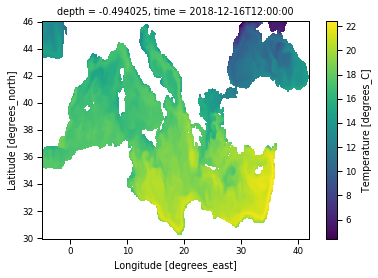

In [7]:
ds[var_name_ds].isel(time=11, depth=0).plot();

## Create and train model
***

In this section, you can create your own model using the number of classes *K* and the feature given as input. Then, the model is trained (__fitted__) to the training dataset and profiles are classified (__predict__) in order to make some useful plots in the next section.

### Create PCM

In [8]:
# pcm feature
z = ds[z_dim]
pcm_features = {var_name_mdl: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model

In [9]:
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl : var_name_ds}

m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 9.241809

## Development plots
***

The plots in this section will help you __optimize__ the model parameters (especially the number of classes) and to take a look at how the classification behaves. Some of the functions contained in the Plotter class will be used in this section.

In [10]:
P = Plotter(ds, m)

#### __1. Mask__

When fitting the model, the *pyxpcm* sotfware __preprocessed__ the data to select profiles without NaN values over the depth range of the PCM. NaNs can be found when the profile is not deep enough, for instance. These profiles are masked and not used to fit the model.  

You can plot the final mask to know where are the profiles used to train the PCM. As we are working with a time series, you should choose a time slice to be plotted.

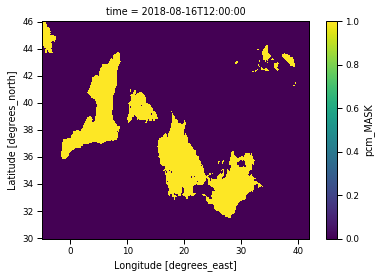

In [11]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=z_dim)
mask.plot()

#### __2. BIC__
<a id='BIC_plot'></a>

The BIC ([Bayesian Information Criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) can be used to __optimize the number of classes__ in the model, trying not to over-fit or under-fit the data. To compute this index, the model is fitted to the training dataset for a range of K values from 0 to 20. A __minimum__ in the BIC curve will give you the optimal number of classes to be used.

Moreover, for each K range run, a subset of the training dataset is randomly selected in order to use *independent* profiles. Indeed, the ocean exhibits spatial correlations that reduce the real information contained in the training dataset. This has to be taken into account. This turns to our advantage here because the grid of the dataset allows to draw several subsets of uncorrelated profiles, finally allowing us to compute several times each K range run and hence to compute a standard deviation on the BIC metric.

The spatial correlation scale to consider is determined by the user. 
You should also choose a training set with limited correlation in time. 
Values in the cell below are ok for the Mediterranean sea example shown here.
If you want to try another geographical selection or another variable you may change these numbers.

You can also choose the number of runs and the maximum number of classes, taking into account that increasing this numbers will increase the computation time. 

__User input__

In [12]:
corr_dist = 50 # correlation distance in km
time_steps = ['2018-01','2018-07']  # time steps to be used into account
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

__BIC calculation__

Calculation is parallelized but this can take a few minutes to run

In [13]:
BIC, BIC_min = BIC_calculation(ds=ds, coords_dict=P.coords_dict, 
                               corr_dist=corr_dist, time_steps=time_steps, 
                               pcm_features=pcm_features, features_in_ds=features_in_ds, z_dim=z_dim, 
                               Nrun=Nrun, NK=NK)

__BIC plot__

Figure saved in figures/BIC_EX.png


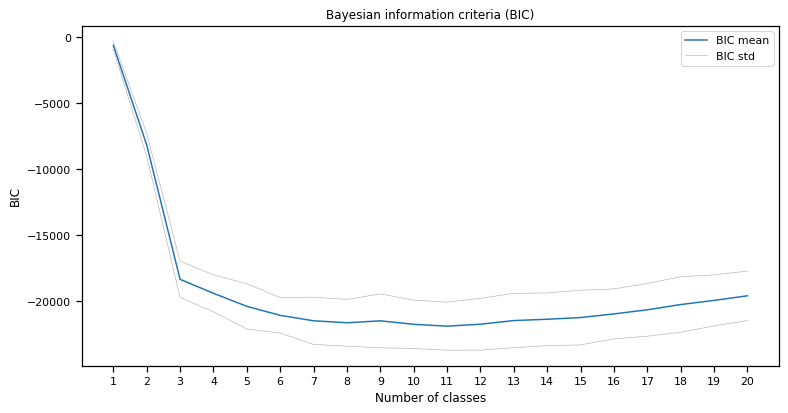

In [14]:
plot_BIC(BIC, NK=NK)
P.save_BlueCloud('figures/BIC_EX.png', bic_fig='yes')

__Optimized number of classes__

In [15]:
BIC_min

11

If this is not the number of classes you chose in the beginning of the notebook, don't worry, you will fit your model again with the appropriate number of classes at the end of the notebook.

The BIC curve may not show a clear minimum. This can be an indication that some profiles remained correlated in the training set, so try to adjust more precisely the correlation scale.

If the BIC curve has a clear minimum, don't forget to take into account the standard deviation. The BIC curve indicates a statistical optimum, so if the minimum is not above the standard deviation range, then it is indicative of an optimal **range** rather than a precise value. In this case, use your expertise to choose the number of classes (within the BIC allowed range) leading to ocean patterns that simply make the most sense to you.

#### __3. Robustness__

The PCM robustness represents a useful scaled __probability__ of a profile to belong to a class. If a lot of profiles show very low values you should maybe change the number of classes. 


You must select the time slice you want to plot in the function below.

In [16]:
m.fit(ds, features=features_in_ds, dim=z_dim);
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (depth: 41, latitude: 193, longitude: 565, pcm_class: 6, time: 12)
Coordinates:
  * depth               (depth) float32 -0.494 -1.541 ... -1.942e+03 -2.225e+03
  * latitude            (latitude) float64 30.0 30.08 30.17 ... 45.83 45.92 46.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12...
  * longitude           (longitude) float64 -5.0 -4.917 -4.833 ... 41.92 42.0
Dimensions without coordinates: pcm_class
Data variables:
    thetao              (time, depth, latitude, longitude) float32 nan ... nan
    PCM_LABELS          (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_POST            (pcm_class, time, latitude, longitude) float64 nan .....
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 5 5 5 5 5 ... 5 5 5 5
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

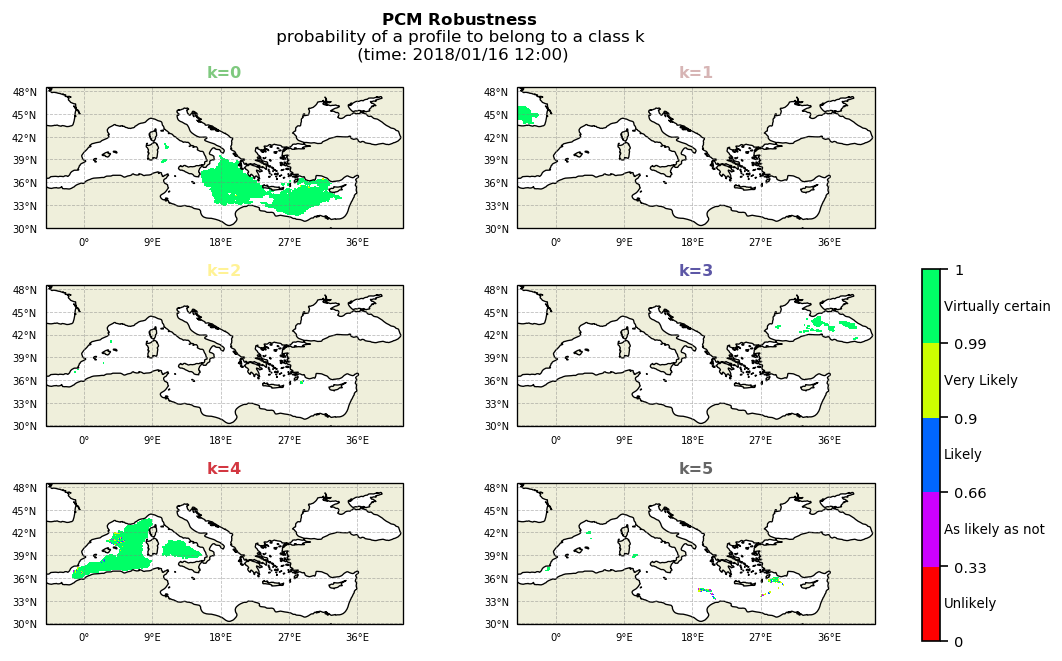

In [17]:
P.plot_robustness(time_slice="2018-01-01")

## Refit and save model
***

As you now know which is the __best number of classes__ to classify your dataset profiles, you can train (fit) the model again with the appropriate number of classes.

In [18]:
# appropriate number of classes
K = BIC_min
K = 8

m = pcm(K=K, features=pcm_features)
m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/pyxpcm/xarray.py:89: UserWarning: PCM_LABELS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


<xarray.Dataset>
Dimensions:             (depth: 41, latitude: 193, longitude: 565, pcm_class: 6, time: 12)
Coordinates:
  * depth               (depth) float32 -0.494 -1.541 ... -1.942e+03 -2.225e+03
  * latitude            (latitude) float64 30.0 30.08 30.17 ... 45.83 45.92 46.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12...
  * longitude           (longitude) float64 -5.0 -4.917 -4.833 ... 41.92 42.0
Dimensions without coordinates: pcm_class
Data variables:
    thetao              (time, depth, latitude, longitude) float32 nan ... nan
    PCM_LABELS          (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_POST            (pcm_class, time, latitude, longitude) float64 nan .....
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 5 5 5 5 5 ... 5 5 5 5
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

If you are satisfied with you model, you can save it in the *models/* folder and use it with the ``predict_PCMlabels_and_plot.IPYNB`` notebook to classify (predict) a dataset and plot the results corresponding to __ocean pattern indicators__.

In [19]:
m.to_netcdf('models/test_model_mediterranean_temp_2018_k8.nc')